# 1. 사전 세팅

In [ ]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/2. 당뇨 환자 재입원 예측 모델링"

# 2. 문제 정의

---

    당뇨병은 세계 성인 인구의 9% 이상에 영향을 미치고 있으며, 점점 더 증가하고 있다.
    당뇨 환자는 지속적인 관찰과 치료가 필요하며, 중증 환자는 더 세심한 관리가 필요하다.
    이를 위해 30일 이내 재입원해야하는 환자를 예측하는 모델을 생성할 것이다.
    그리고 모델 성능 향상을 위해 Error의 분포를 분석해 성능을 향상시킬 것이다.

# 3. 데이터 확인

## 3.1. 데이터 명세

---

| Column | Description |
|:----|:----|
| Features | 환자 입원 기간 내 관련 정보 |
| Class | readmit_30_days |

## 3.2. 데이터 살펴보기

In [ ]:
# openml API를 사용해 당뇨 환자 데이터 읽어오기
from sklearn.datasets import fetch_openml

df, y = fetch_openml(data_id=43874, as_frame=True, return_X_y=True)

In [ ]:
df.info()

In [ ]:
df.sample(5)

## 3.3. 데이터 가공 명세

---

| 명세 | 내용 |
|:----|:----|
| 가공 범위 | <input type="checkbox" checked> Feature(Column) 변형<br> <input type="checkbox">기간 단위 데이터 분석 및 Big Volume 특성을 반영하기 위한 데이터 증강<br> <input type="checkbox" checked>다양한 Table을 참조하기 위한 데이터 분할|
| 가공 상세 | <b>Feature(Column) 변형</b><br><br>- OnehotEncoding Transform을 통한 Feature 추가 생성<br>- 타겟에 직접적으로 관련된 변수 삭제해 모델 영향도 제거<br><br><b>데이터 분할</b><br><br>- 학습/검증을 위해 Train:Test=7:3으로 분할 |
| 가공 결과 | <b>As is</b><br><br>- row: 101766 / column: 34 / table: 1<br><br> <b>To be</b><br><br>- row: 101766 / column: 54(+20) / table: 1  |

# 4. 문제 해결 프로세스 정의

---

▸ 문제

    퇴원한 환자들 중 재입원하는 중증 환자들이 늘어나고 있다.
    
▸ 기대 효과

    재입원 환자들을 예측함으로써 중증 환자 사전 조치와 모니터링을 시행할 수 있다.
    그리고 중증 환자의 생존율이 높아질 수 있다.

▸ 해결 방안

    Binary Classification으로 30일 이내 재입원할 환자들을 분류한다.
    Class Weight가 오류에 미치는 영향을 분석하고, Feature Importance까지도 알아본다.

▸ 성과 측정

    에러/Cohort 분석으로 점진적인 성능 향상 예정

▸ 현업 적용

    모델 성능 하락 시 분석 포인트 탐색

# 5. 데이터 전처리 및 EDA

## 5.1. 데이터 전처리

In [ ]:
# 필요 라이브러리 설치
!pip install lightgbm optuna shap --quiet

In [ ]:
import math
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb
import optuna

# from responsibleai import RAIInsights
# from raiwidgets import ResponsibleAIDashboard
# from raiwidgets.cohort import Cohort, CohortFilter, CohortFilterMethods
# Numpy 때문에 호환이 안 된다...
# import shap

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

### 5.1.1. Target 유의 변수 제거

In [ ]:
df['readmitted'].value_counts()

| readmitted | count |
|:---:|:----|
| NO | 54864 |
| >30 | 35545 |
| <30 | 11357 |



In [ ]:
df['readmit_binary'].value_counts()

| readmit_binary | count |
|:---:|:----|
| 0 | 54864 |
| 1 | 46902 |

In [ ]:
# 실제 타겟
y.value_counts()

| readmit_30_days | count |
|:---:|:----|
| 0 | 90409 |
| 1 | 11357 |



```
위에서도 알 수 있듯, 2개의 변수는 y와 직접적으로 상관 관계가 보이기 때문에 학습 Feature로 사용할 수 없다.
y와 직접적으로 상관 관계가 있는 변수들을 Feature로 사용할 경우, 모든 경우 100%에 가까운 정확도를 보이게 되며,
이는 정답을 보여주는 것과 동일하기에 정상적인 모델이라고 할 수 없다.
```



### 5.1.2. 인코딩

In [ ]:
# 함수 정의
def transform_data(X_):
    # 변수 제거
    X = X_.drop(['readmitted', 'readmit_binary'], axis=1)

    # 바이너리 인코딩
    bool_cols = X.select_dtypes(include='category').columns.tolist()
    X[bool_cols] = X[bool_cols].astype(str).replace({'True':1, 'False':0})
    print(bool_cols)

    # 원핫 인코딩
    cat_cols = X.select_dtypes(include='object').columns.tolist()
    print(cat_cols)

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder_np = encoder.fit_transform(X[cat_cols].astype('category'))
    X[encoder.get_feature_names_out(cat_cols)] = encoder_np.astype(int)

    # 원본 열 제거
    X.drop(cat_cols, axis=1, inplace=True)

    return X

In [ ]:
X = transform_data(df)



```
['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
['race', 'gender', 'age', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']
```



In [ ]:
print(f'원본 데이터 Feature 수: {len(df.columns)}')
print(df.columns)



```
원본 데이터 Feature 수: 24
Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'primary_diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'readmitted', 'readmit_binary'],
      dtype='object')
```



In [ ]:
print(f'변환 데이터 Feature 수: {len(X.columns)}')
print(X.columns)



```
변환 데이터 Feature 수: 54
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_'30 years or younger'',
       'age_'30-60 years'', 'age_'Over 60 years'',
       'discharge_disposition_id_'Discharged to Home'',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'primary_diagnosis_'Genitourinary Issues'',
       'primary_diagnosis_'Musculoskeletal Issues'',
       'primary_diagnosis_'Respiratory Issues'', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Other', 'max_glu_serum_>200', 'max_glu_serum_>300',
       'max_glu_serum_None', 'max_glu_serum_Norm', 'A1Cresult_>7',
       'A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm', 'insulin_Down',
       'insulin_No', 'insulin_Steady', 'insulin_Up', 'change_Ch', 'change_No',
       'diabetesMed_No', 'diabetesMed_Yes'],
      dtype='object')
```



## 5.2. 데이터셋 분할

In [ ]:
rand = 42
os.environ['PYTHONHASHSEED'] = str(rand)
np.random.seed(rand)

In [ ]:
label = ['NO or > 30 days', '< 30 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand)
df_test = df.loc[X_test.index]

In [ ]:
# 71236 rows × 54 columns
X_train

In [ ]:
# 30530 rows × 54 columns
X_test

## 5.3. 모델 Evaluation 함수 정의

---

    모델을 생성하면 성능에 대한 평가를 하기 위해 evalutaion 함수를 정의하고 시작하는 것이 좋다.

In [ ]:
# Accuracy, Precision, Recall, F1 score를 도출하고, Confusion Matrix 시각화하는 함수
def evaluate_class(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
    # 2차원인 것들도 1차원으로 쭉 늘려주는 squeeze 함수
    y_train_pred = fitted_model.predict(X_train).squeeze()

    # 이진 분류가 되지 않았다면(모델이 연속 확률값(0.7, 0.1) 등을 반환했다면)
    if len(np.unique(y_train_pred)) > 2:
        # thresh에 따라 이진 분류 다시 해주기
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:
        y_test_prob = fitted_model.predict_proba(X_test)[:, 1]
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)

    roc_auc_test = metrics.roc_auc_score(y_test, y_test_prob)

    cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cf_matrix.ravel()

    acc_train = metrics.accuracy_score(y_train, y_train_pred)
    acc_test = metrics.accuracy_score(y_test, y_test_pred)

    pre_test = metrics.precision_score(y_test, y_test_pred)

    rec_test = metrics.recall_score(y_test, y_test_pred)
    f1_test = metrics.f1_score(y_test, y_test_pred)

    mcc_test = metrics.matthews_corrcoef(y_test, y_test_pred)

    if plot:
        print(f'Accuracy Train: {acc_train:.4f}\t\tAccuracy Test: {acc_test:.4f}')
        print(f'Precision Test: {pre_test:.4f}\t\tRecall Test: {rec_test:.4f}')
        print(f'ROC-AUC Test: {roc_auc_test:.4f}\t\tF1 Test: {f1_test:.4f}\t\tMCC Test: {mcc_test:.4f}')

        plt.figure(figsize=(6, 5))

        if pct:
            ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
                             fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            ax = sns.heatmap(cf_matrix, annot=True,
                             fmt='d', cmap='Blues', annot_kws={'size':16})

        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Observed', fontsize=12)
        plt.show()

        return y_train_pred, y_test_prob, y_test_pred

    else:
        t = cf_matrix.sum()
        metrics_dict = {'accuracy_train': acc_train, 'accuracy_test': acc_test, 'precision': pre_test,
                        'recall': rec_test, 'roc_auc': roc_auc_test, 'f1': f1_test,
                        'tn%': tn/t, 'fp%': fp/t, 'fn%': fn/t, 'tp%': tp/t}

        return metrics_dict

# 6. 모델 학습

## 6.1. LightGBM Classifier 모델 학습

In [ ]:
# LightGBMClassifier
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1)
clf.fit(X_train, y_train)

_ = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.8888		Accuracy Test: 0.8877
Precision Test: 0.0000		Recall Test: 0.0000
ROC-AUC Test: 0.6469		F1 Test: 0.0000		MCC Test: -0.0029
```

    숫자만 봤을 때는 정확도가 매우 높은 것으로 보이지만, Precision과 Recall이 매우 낮아 전반적인 성능은 나쁘다.
    중증 환자의 케이스가 10% 정도라 중증 환자는 없다고 모델이 판단한 것이다.



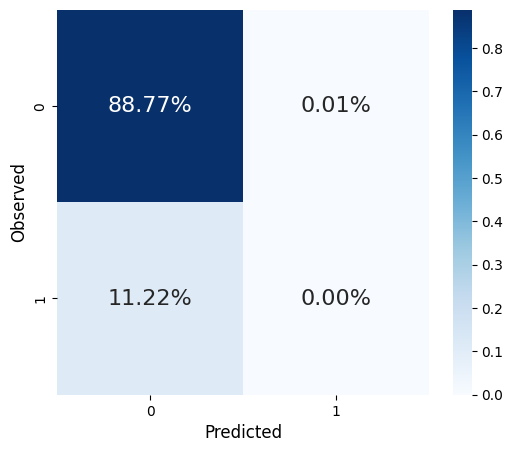

    모델은 기본적으로 Positive 클래스를 예측할 때, 보수적인 접근 방법으로 모델을 생성하기 때문에 너무 많은 위험을 감수하지 않는다.
    해결책은 Positive 클래스에 더 많은 비중을 두도록 강제하는 Hyper Parameter를 활용하는 것이다.
    클래스 가중치를 부여할 수 있는 방법은 여러 가지가 있지만, 그 중 LGBM이 가지고 있는 scale_pos_weight를 활용해 볼 예정

## 6.1.1. 클래스 가중치 부여

In [ ]:
def_scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f'Default scale pos weight: {def_scale_pos_weight:.2f}')



```
Default scale pos weight: 7.96
```



In [ ]:
# 해당 비율을 적용하여 다시 모델 학습
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight)
clf.fit(X_train, y_train)
_ = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.6381		Accuracy Test: 0.6086
Precision Test: 0.1638		Recall Test: 0.6064
ROC-AUC Test: 0.6458		F1 Test: 0.2580		MCC Test: 0.1379
```



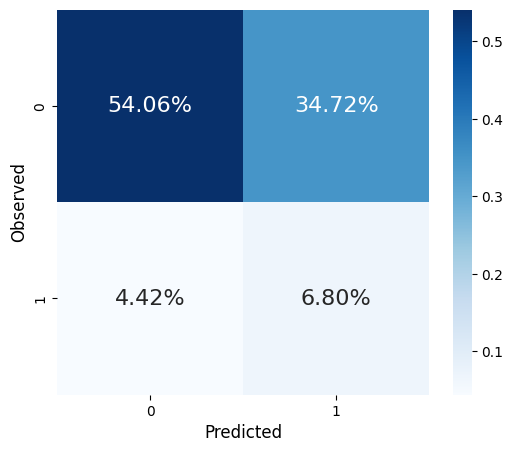

    실제로 모델 성능은 향상되었으나 여전히 상당 수준의 오탐지가 존재한다.

In [ ]:
# 그리고 두 배로 그 비율을 늘리게 되면 오탐지도 똑같이 두 배
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight*2)
clf.fit(X_train, y_train)
_ = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.3354		Accuracy Test: 0.3157
Precision Test: 0.1293		Recall Test: 0.8893
ROC-AUC Test: 0.6438		F1 Test: 0.2258		MCC Test: 0.0997
```



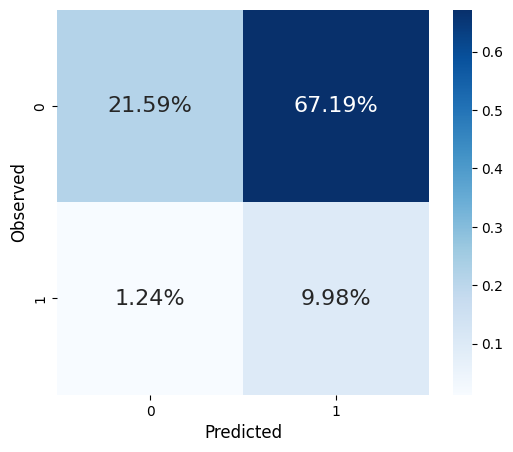

In [ ]:
# 그리고 해당 비율을 반으로 줄이게 되면 모델이 조금 보수적으로 변함
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight/2)
clf.fit(X_train, y_train)
_ = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.8771		Accuracy Test: 0.8617
Precision Test: 0.2232		Recall Test: 0.0937
ROC-AUC Test: 0.6485		F1 Test: 0.1320		MCC Test: 0.0782
```



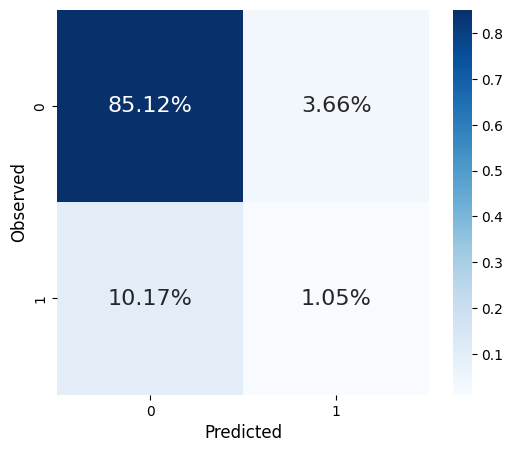